## **Import libraries**

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime

## **Import data**

In [129]:
# Specify the quiniela you want to import (i.e., nacional, buenos_aires, misiones, etc.)
quiniela_name = 'nacional'
raw_df = pd.read_csv('./data_source/quiniela_{}.csv'.format(quiniela_name))

df_quiniela = raw_df.copy()
df_quiniela.head()

,lottery_date,quiniela,period,position,result
0,2014-11-01,nacional,primera,1,3940
1,2014-11-01,nacional,primera,2,6857
2,2014-11-01,nacional,primera,3,609
3,2014-11-01,nacional,primera,4,8018
4,2014-11-01,nacional,primera,5,3232


## **Explore and clean data**

In [130]:
# Check data types, null and total values.
df_quiniela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191060 entries, 0 to 191059
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   lottery_date  191060 non-null  object
 1   quiniela      191060 non-null  object
 2   period        191060 non-null  object
 3   position      191060 non-null  int64 
 4   result        191060 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.3+ MB


### Fix data types
*Note: 'position' is categorical ordinal data, but to the effects of creating position groups -see betting options-, it will be treated as numerical data.*

In [131]:
# Modify 'lottery_date' to type DATE.
df_quiniela['lottery_date'] = pd.to_datetime(df_quiniela['lottery_date'])
# Parse 'result' as TEXT with 4 characters an leading zeros. This feature is, in essence, categorical nominal data.
df_quiniela['result'] = df_quiniela['result'].astype(str).str.zfill(4)

df_quiniela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191060 entries, 0 to 191059
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   lottery_date  191060 non-null  datetime64[ns]
 1   quiniela      191060 non-null  object        
 2   period        191060 non-null  object        
 3   position      191060 non-null  int64         
 4   result        191060 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 7.3+ MB


In [132]:
# Check leading zeros for 'result'
df_quiniela.head()

,lottery_date,quiniela,period,position,result
0,2014-11-01,nacional,primera,1,3940
1,2014-11-01,nacional,primera,2,6857
2,2014-11-01,nacional,primera,3,0609
3,2014-11-01,nacional,primera,4,8018
4,2014-11-01,nacional,primera,5,3232


### Add new columns, splitting results by betting options
This features will allow us to analyze occurrences by types of bets availables
(1 digit, 2 digits, 3 digits, 4 digits - https://www.laquinieladetucuman.com.ar/quiniela-nacional/cuanto-paga-premios)
> To analyze results individually and grouped by number of digits, the new columns will be formatted as numbers

In [133]:
# Four digits
df_quiniela['digits_4'] = df_quiniela['result'].astype(int)
# Three digits
df_quiniela['digits_3'] = df_quiniela['result'].str[-3:].astype(int)
# Two digits
df_quiniela['digits_2'] = df_quiniela['result'].str[-2:].astype(int)

# First digit column
df_quiniela['first_digit'] = df_quiniela['result'].str[-4].astype(int)
# Second digit column
df_quiniela['second_digit'] = df_quiniela['result'].str[-3].astype(int)
# Third digit column
df_quiniela['third_digit'] = df_quiniela['result'].str[-2].astype(int)
# Fourth & One digit column
df_quiniela['fourth_digit'] = df_quiniela['result'].str[-1].astype(int)

df_quiniela.head()

,lottery_date,quiniela,period,position,result,digits_4,digits_3,digits_2,first_digit,second_digit,third_digit,fourth_digit
0,2014-11-01,nacional,primera,1,3940,3940,940,40,3,9,4,0
1,2014-11-01,nacional,primera,2,6857,6857,857,57,6,8,5,7
2,2014-11-01,nacional,primera,3,0609,609,609,9,0,6,0,9
3,2014-11-01,nacional,primera,4,8018,8018,18,18,8,0,1,8
4,2014-11-01,nacional,primera,5,3232,3232,232,32,3,2,3,2


In [134]:
# Check main statistics to validate data
df_quiniela.describe()

,position,digits_4,digits_3,digits_2,first_digit,second_digit,third_digit,fourth_digit
count,191060.000000,191060.000000,191060.000000,191060.000000,191060.000000,191060.000000,191060.000000,191060.000000
mean,10.500000,5008.019366,498.713388,49.463415,4.509306,4.492500,4.495959,4.503821
std,5.766296,2886.793826,288.682076,28.864417,2.872757,2.872592,2.872816,2.873970
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.750000,2507.000000,248.000000,24.000000,2.000000,2.000000,2.000000,2.000000
50%,10.500000,5019.000000,497.000000,49.000000,5.000000,4.000000,4.000000,5.000000
75%,15.250000,7504.000000,748.000000,74.000000,7.000000,7.000000,7.000000,7.000000
max,20.000000,9999.000000,999.000000,99.000000,9.000000,9.000000,9.000000,9.000000


### Add position group
This feature will allow us to analyze occurrences by betting options in position groups
(a 1, a los 5, a los 10, a los 15, a los 20 - https://www.laquinieladetucuman.com.ar/quiniela-nacional/cuanto-paga-premios)

In [135]:
# Function to classify positions in groups
def classify_positions(position_number):

    if position_number == 1: return 'a_1'
    elif position_number <= 5: return 'a_los_5'
    elif position_number <= 10: return 'a_los_10'
    elif position_number <= 15: return 'a_los_15'
    elif position_number <= 20: return 'a_los_20'

In [136]:
# Create new column and apply classification of position groups to each occurrence
df_quiniela['position_group'] = df_quiniela['position'].apply(lambda x: classify_positions(x))

# Check classification results
df_quiniela.head(21)

,lottery_date,quiniela,period,position,result,digits_4,digits_3,digits_2,first_digit,second_digit,third_digit,fourth_digit,position_group
0,2014-11-01,nacional,primera,1,3940,3940,940,40,3,9,4,0,a_1
1,2014-11-01,nacional,primera,2,6857,6857,857,57,6,8,5,7,a_los_5
2,2014-11-01,nacional,primera,3,0609,609,609,9,0,6,0,9,a_los_5
3,2014-11-01,nacional,primera,4,8018,8018,18,18,8,0,1,8,a_los_5
4,2014-11-01,nacional,primera,5,3232,3232,232,32,3,2,3,2,a_los_5
5,2014-11-01,nacional,primera,6,9538,9538,538,38,9,5,3,8,a_los_10
6,2014-11-01,nacional,primera,7,4258,4258,258,58,4,2,5,8,a_los_10
7,2014-11-01,nacional,primera,8,3722,3722,722,22,3,7,2,2,a_los_10
8,2014-11-01,nacional,primera,9,2182,2182,182,82,2,1,8,2,a_los_10
9,2014-11-01,nacional,primera,10,6112,6112,112,12,6,1,1,2,a_los_10


### Check distributions and statistics

In [171]:
# Check how many values we have for each of the periods and position groups
pd.pivot_table(
    df_quiniela,
    index=['period'],
    columns='position_group',
    values='result',
    aggfunc=np.count_nonzero,
    margins=True,
    margins_name='Total'
)

position_group,a_1,a_los_10,a_los_15,a_los_20,a_los_5,Total
period,,,,,,
matutina,2384,11920,11920,11920,9536,47680
nocturna,2398,11990,11990,11990,9592,47960
primera,2409,12045,12045,12045,9636,48180
vespertina,2362,11810,11810,11810,9448,47240
Total,9553,47765,47765,47765,38212,191060


In [138]:
# Create function to display distributions based on period, digit options for results, and position group (optional)
def display_distribution(period_in, number_in, position_in=''):

    plt.figure(figsize=(15,3))
    # Determine the title text to be displayed, depending on what -if any- position group is passed as an argument
    position_string = ('positon ' + position_in) if position_in != '' else 'no particular position'
    # Define the title of the chart, based on the selections, to make it descriptive of what you are looking at
    plt.title('Results distribution by number of digits in {} {}, for {} and {}'.format(quiniela_name, period_in, number_in, position_string), fontsize=20)

    # Create a temporary dataframe, filtering by the period and position group passed as an argument to the function
    df_temp = df_quiniela[
        (df_quiniela['period'] == period_in) 
        & (df_quiniela['position_group'] == position_in if position_in != '' else df_quiniela['position'] <= 20)
        ].sort_values(by=number_in)

    # Change the number of bins based on number of digits: 100 if it is more than 1, 10 if it is one digit
    bin_number = 100 if 'digits' in number_in else 10

    # Create the histogram for the selected number
    sns.histplot(df_temp[number_in], bins=bin_number)
    # plt.hist(df_temp[number_in], bins=bin_number)

    return plt.show()

>- *What is the distribution of the results by individual digits, regardless of the position, for each of the periods?*<br>
>&emsp;Distributions for a specific digit, at any position, are pretty much uniform<br>
>
>- *What are the modes for the digits in each period?*<br>
>&emsp;See [individual modes](#individual_modes)<br>

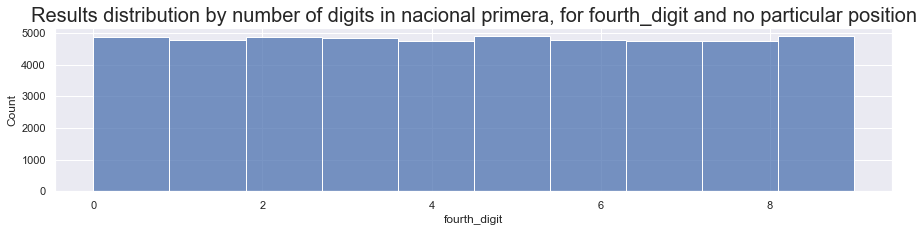

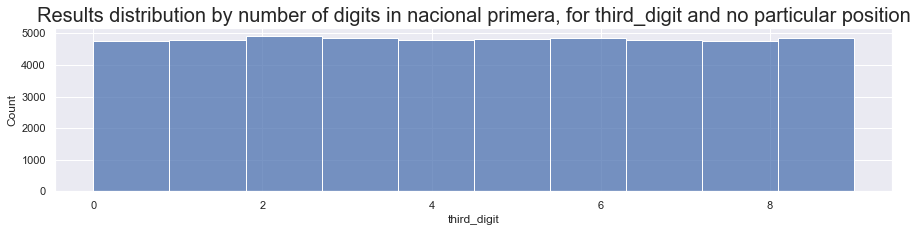

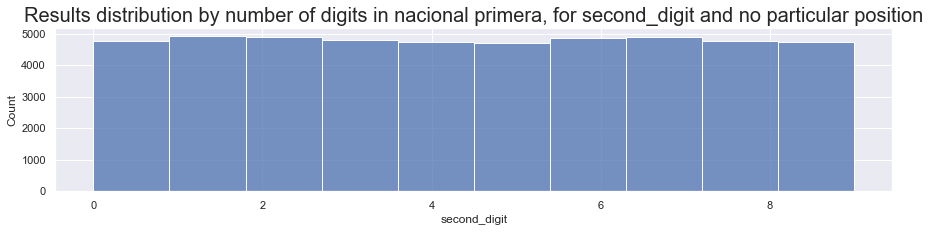

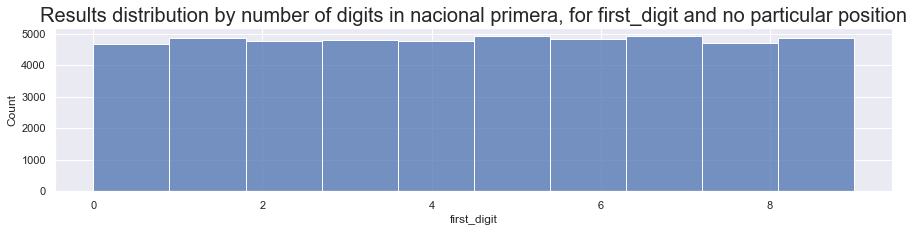

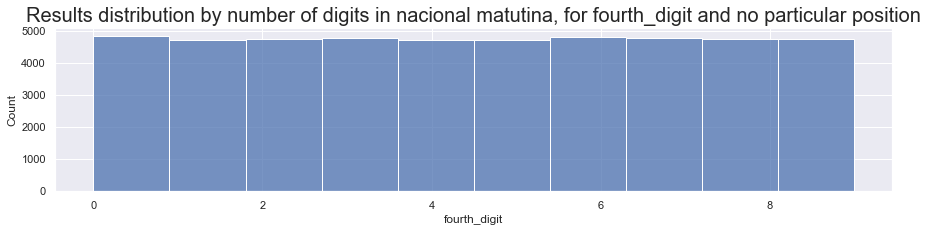

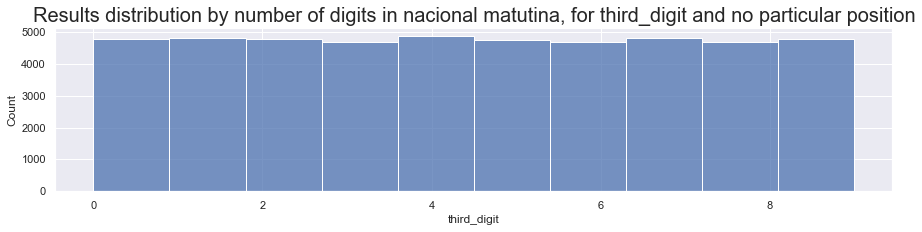

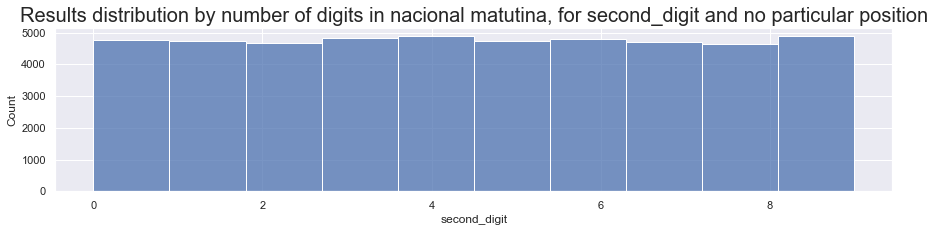

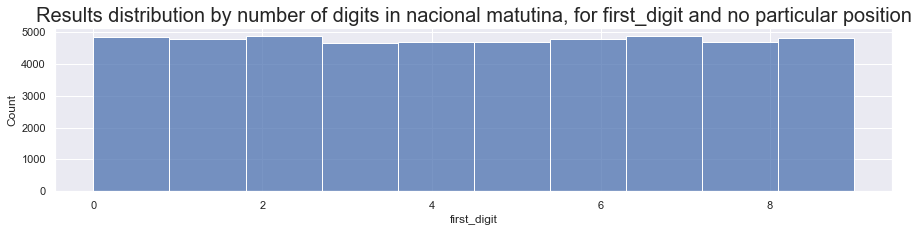

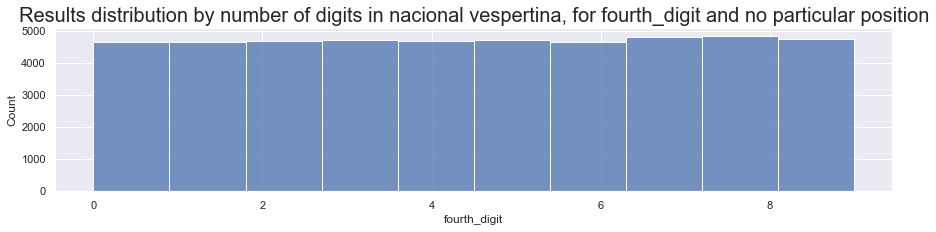

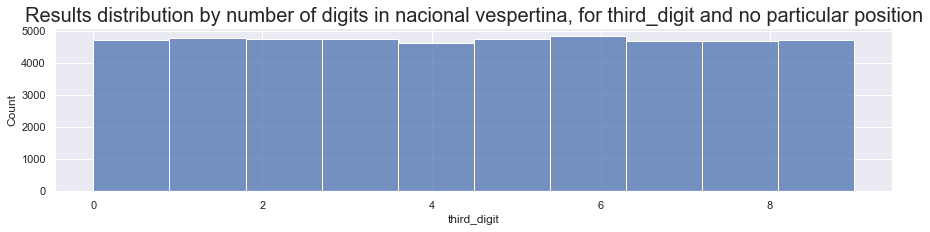

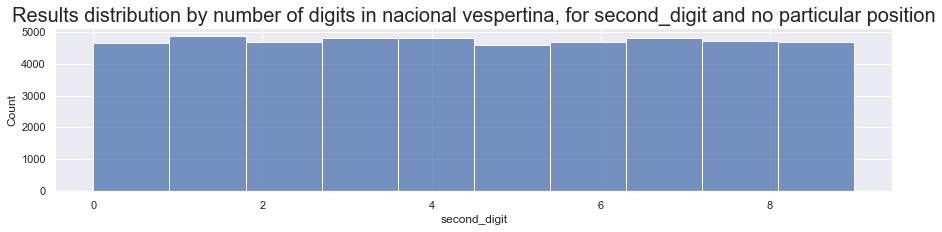

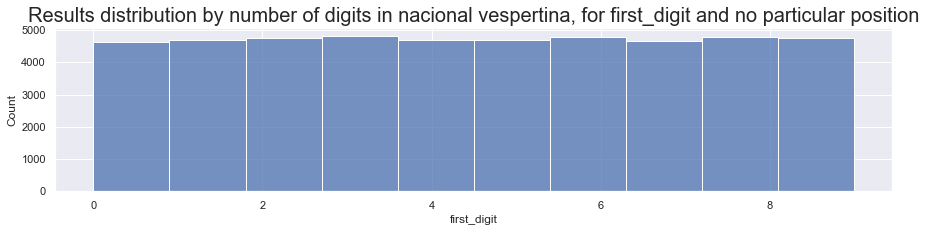

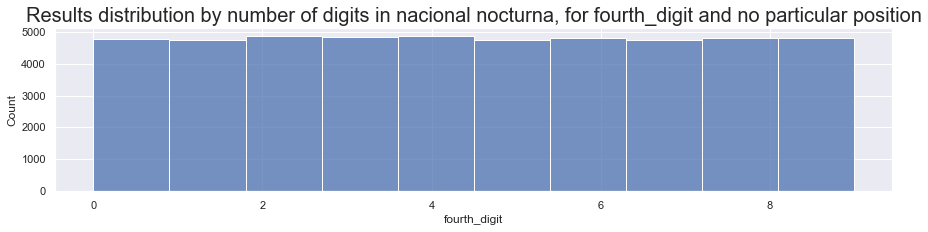

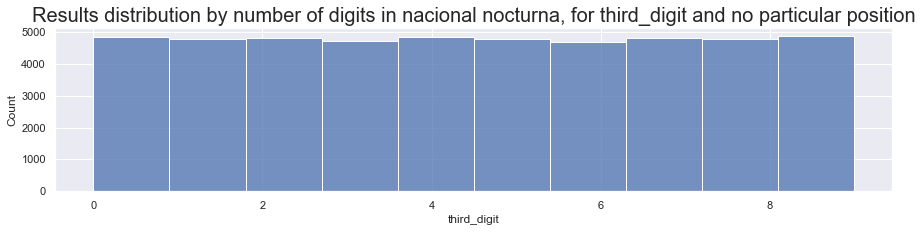

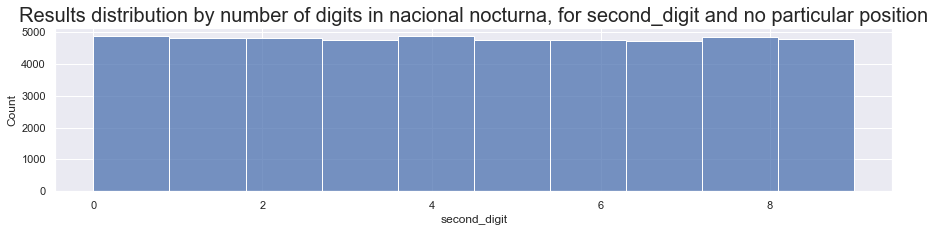

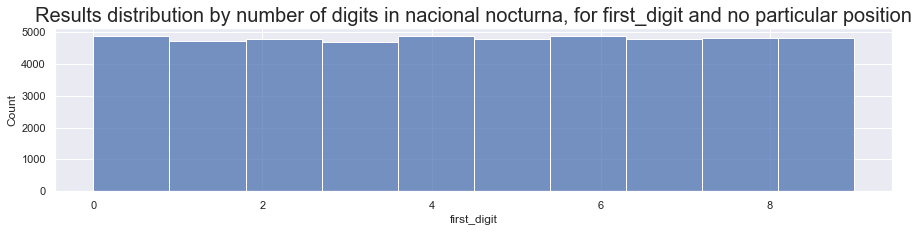

In [139]:
# Check the Quiniela's results distribution by periods
plot_period = 'primera'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

plot_period = 'matutina'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

plot_period = 'vespertina'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

plot_period = 'nocturna'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

<a id='individual_modes'>Check individual modes</a>

In [140]:
# Create table, grouping by period and calculating the mode for each digit
df_quiniela.groupby(['period']).agg(
    digit_1_mode=('first_digit', lambda x: x.mode()),
    digit_2_mode=('second_digit', lambda x: x.mode()),
    digit_3_mode=('third_digit', lambda x: x.mode()),
    digit_4_mode=('fourth_digit', lambda x: x.mode())
)

,digit_1_mode,digit_2_mode,digit_3_mode,digit_4_mode
period,,,,
matutina,2,4,4,0
nocturna,0,4,9,4
primera,5,1,2,9
vespertina,3,1,6,8


>- *What is the distribution of the results by digit groups, for the first two position groups, taking as example the 'primera' period?*<br>
>&emsp;Looking at more than one digit, distributions are multimodal, with larger variations for results in the first position<br>
>
>- *What are the modes for the digits in each period, by position group?*<br>
>&emsp;See [position groups modes](#position_groups_modes)<br>

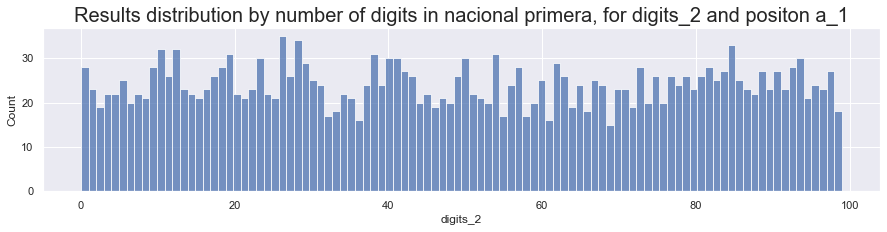

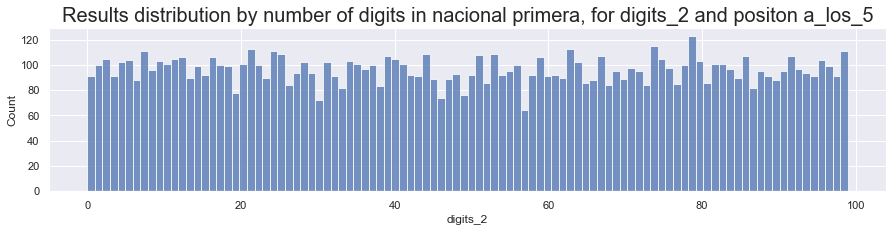

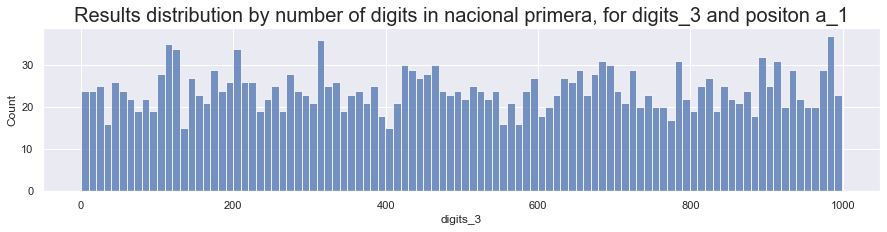

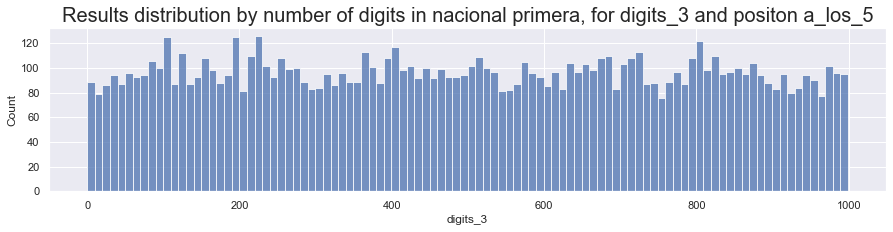

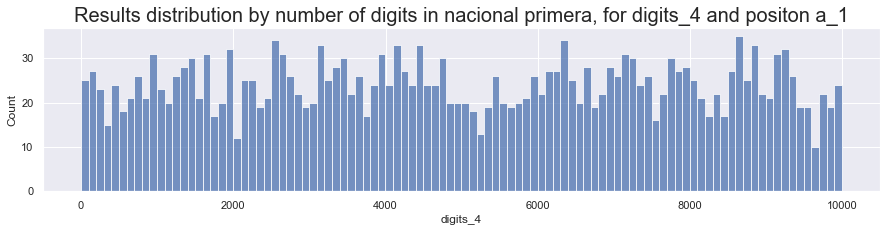

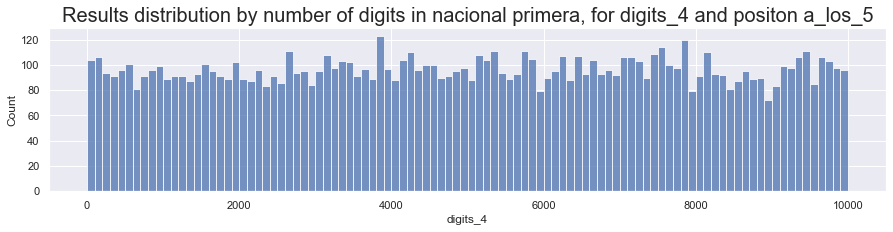

In [141]:
# Check the Quiniela's results distribution by position groups
plot_period = 'primera'
display_distribution(plot_period, 'digits_2', 'a_1')
display_distribution(plot_period, 'digits_2', 'a_los_5')
display_distribution(plot_period, 'digits_3', 'a_1')
display_distribution(plot_period, 'digits_3', 'a_los_5')
display_distribution(plot_period, 'digits_4', 'a_1')
display_distribution(plot_period, 'digits_4', 'a_los_5')

<a id='position_groups_modes'>Check modes by position group</a>

In [142]:
# Set width of columns to fit all values
pd.set_option('max_colwidth', None)
# Create table, grouping by period and calculating the mode for each grouped digits, for the first position
df_quiniela[df_quiniela['position_group'] == 'a_1'].groupby(['position_group', 'period']).agg(
    # list() is used to avoid errors. Arrays are not supported as a response
    digit_2_mode=('digits_2', lambda x: list(x.mode())), 
    digit_3_mode=('digits_3', lambda x: list(x.mode())),
    digit_4_mode=('digits_4', lambda x: list(x.mode()))
)

digit_2_mode     digit_3_mode  \
position_group period                                     
a_1            matutina       [11, 44]       [544, 711]   
               nocturna           [41]       [427, 702]   
               primera            [26]  [585, 894, 931]   
               vespertina         [32]            [611]   

                                                                                                                                          digit_4_mode  
position_group period                                                                                                                                   
a_1            matutina    [231, 305, 738, 1334, 1754, 2179, 2188, 2344, 2946, 3699, 3959, 4371, 5126, 5470, 5546, 6140, 6307, 6934, 9458, 9711, 9782]  
               nocturna                                                                                                                         [1858]  
               primera                                                                                                                          [1674]  
               vespertina                                                                                                                 [6602, 8899]

> Since results are always a 4 digit 'number' for each position, and modes are not repeated in groups with lesser digits, we can assume that there is no one result that has been drawned significantly more than the others.
>
> For example, if '1234' would have been the most drawn number overall, mode for 3 digits should have been '234' and mode for 2 digits, '34'.

### Add day, day of the week, and month
This two new features will allow us to analyze occurrences by calendar day, the day of the week, and also by the the month

In [143]:
# Add -calendar- day
df_quiniela['calendar_day'] = df_quiniela['lottery_date'].apply(lambda x: int(x.strftime('%d')))
# Add day of the week - Monday is 0 and Sunday is 6
df_quiniela['day_of_week'] = df_quiniela['lottery_date'].apply(lambda x: int(x.weekday()))
# Add day and month
df_quiniela['month'] = df_quiniela['lottery_date'].apply(lambda x: int(x.strftime('%m')))

df_quiniela.head()

,lottery_date,quiniela,period,position,result,digits_4,digits_3,digits_2,first_digit,second_digit,third_digit,fourth_digit,position_group,calendar_day,day_of_week,month
0,2014-11-01,nacional,primera,1,3940,3940,940,40,3,9,4,0,a_1,1,5,11
1,2014-11-01,nacional,primera,2,6857,6857,857,57,6,8,5,7,a_los_5,1,5,11
2,2014-11-01,nacional,primera,3,0609,609,609,9,0,6,0,9,a_los_5,1,5,11
3,2014-11-01,nacional,primera,4,8018,8018,18,18,8,0,1,8,a_los_5,1,5,11
4,2014-11-01,nacional,primera,5,3232,3232,232,32,3,2,3,2,a_los_5,1,5,11


In [144]:
# Create function to display distributions by the different days of the week
def display_occurrences_in_time(period_in, number_in, position_in=''):

    # Determine the title text to be displayed, depending on what -if any- position group is passed as an argument
    position_string = ('positon ' + position_in) if position_in != '' else 'no particular position'

    # Create 6 subplots (3 rows by 2 columns)
    fig, ax = plt.subplots(3,2, figsize=(30,15))
    plt.subplots_adjust(top=1.1)

    # Define the title of the chart, based on the selections, to make it descriptive of what you are looking at
    plt.suptitle('Results distribution by number of digits in {} {}, for {} and {}'.format(quiniela_name, period_in, number_in, position_string), fontsize=20, y=1.2)

    # Create a temporary dataframe, filtering by the period and position group passed as an argument to the function
    df_temp = df_quiniela[
        (df_quiniela['period'] == period_in) 
        & (df_quiniela['position_group'] == position_in if position_in != '' else df_quiniela['position'] <= 20)
        ].sort_values(by=number_in)

    # Change the number of bins based on number of digits: 100 if it is more than 1, 10 if it is one digit
    bin_number = 100 if 'digits' in number_in else 10

    # Filter and create dataframes for each day of the week
    df_mon = df_temp[df_temp['day_of_week'] == 0]
    df_tue = df_temp[df_temp['day_of_week'] == 1]
    df_wed = df_temp[df_temp['day_of_week'] == 2]
    df_thu = df_temp[df_temp['day_of_week'] == 3]
    df_fri = df_temp[df_temp['day_of_week'] == 4]
    df_sat = df_temp[df_temp['day_of_week'] == 5]

    # Create the histograms for the selections and for each day
    sns.histplot(data=df_mon, x=df_mon[number_in], bins=bin_number, ax=ax[0,0]).set(title='Monday', xlabel=None)
    sns.histplot(data=df_tue, x=df_tue[number_in], bins=bin_number, ax=ax[0,1]).set(title='Tuesday', xlabel=None)
    sns.histplot(data=df_wed, x=df_wed[number_in], bins=bin_number, ax=ax[1,0]).set(title='Wednesday', xlabel=None)
    sns.histplot(data=df_thu, x=df_thu[number_in], bins=bin_number, ax=ax[1,1]).set(title='Thursday', xlabel=None)
    sns.histplot(data=df_fri, x=df_fri[number_in], bins=bin_number, ax=ax[2,0]).set(title='Friday', xlabel=None)
    sns.histplot(data=df_sat, x=df_sat[number_in], bins=bin_number, ax=ax[2,1]).set(title='Saturday', xlabel=None)

    return plt.show()

>- *What is the distribution of the results by digit groups (2 and 3 digits), for the first position, taking as example the 'primera' period?*<br>
>&emsp;Distributions are multimodal<br>
>
>- *What are the modes for the digits in each period, by position group?*<br>
>&emsp;See [modes by the day of the week](#day_of_week_modes)<br>

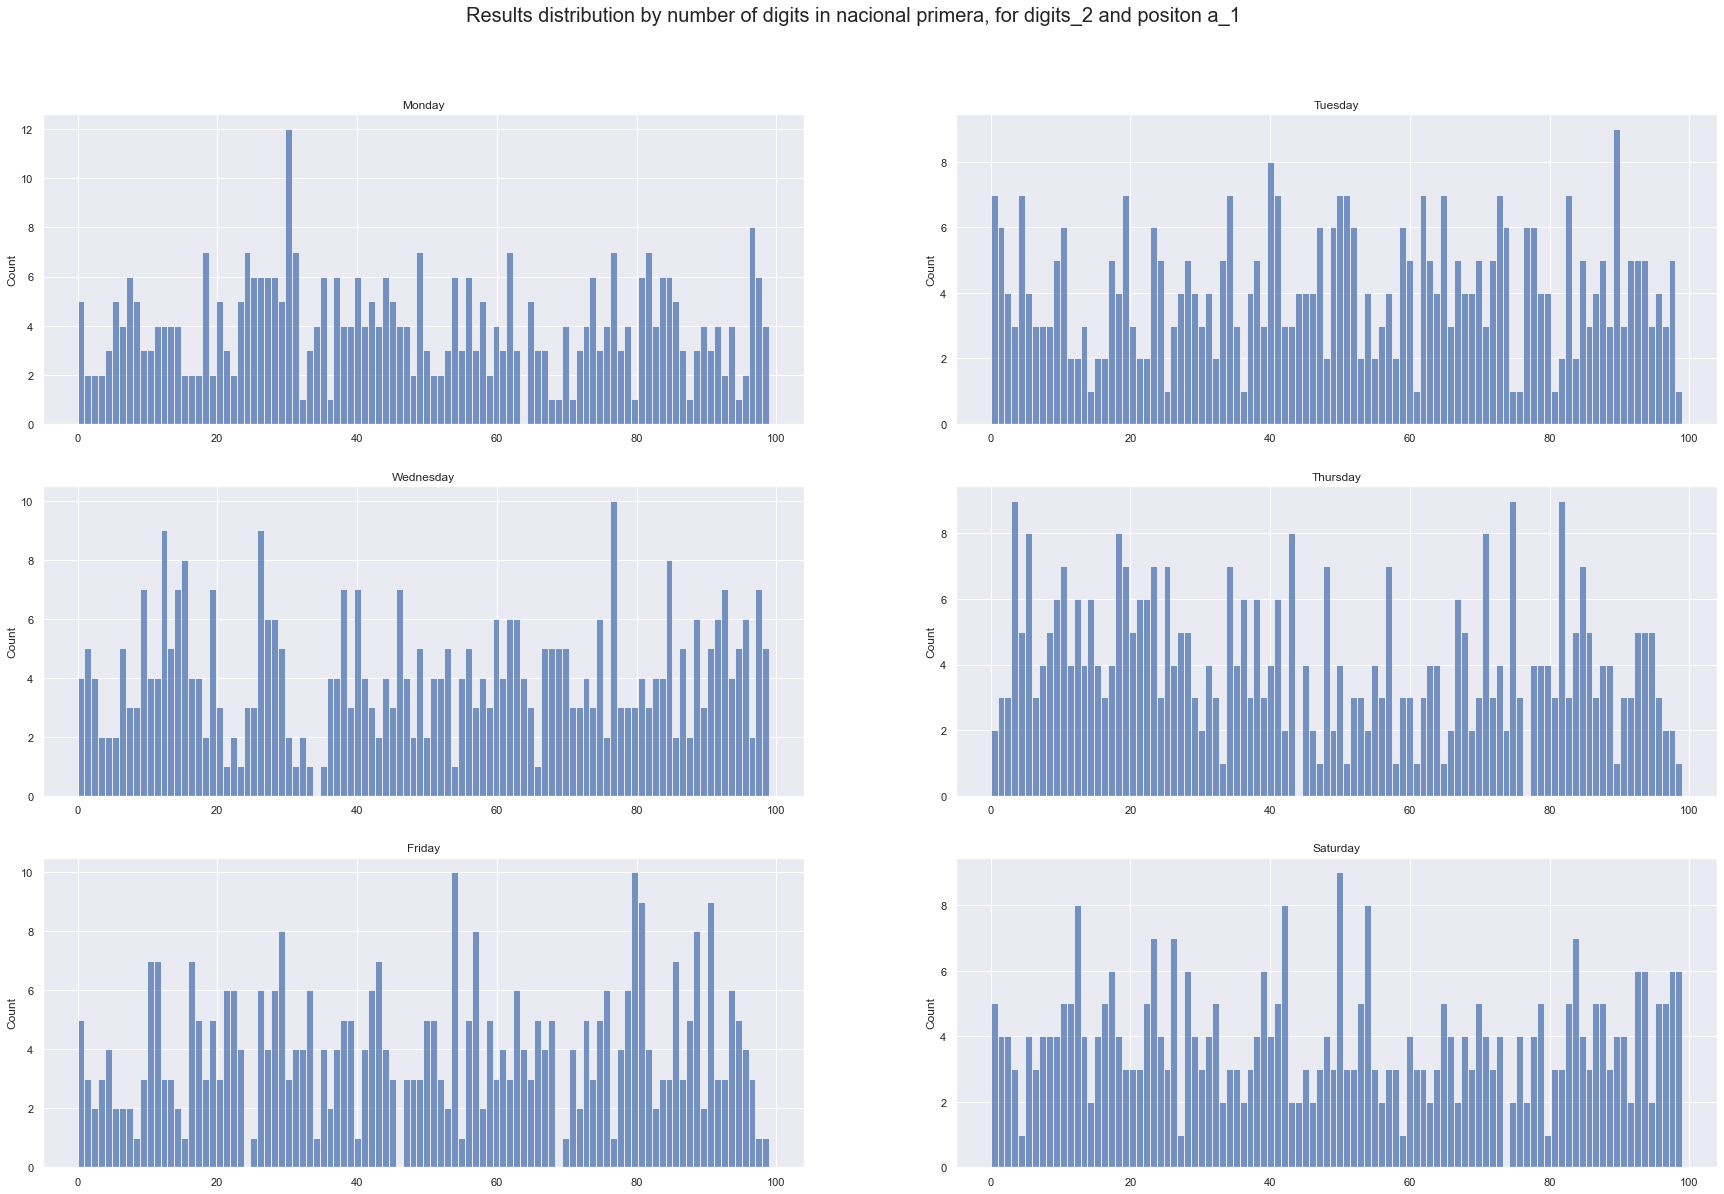

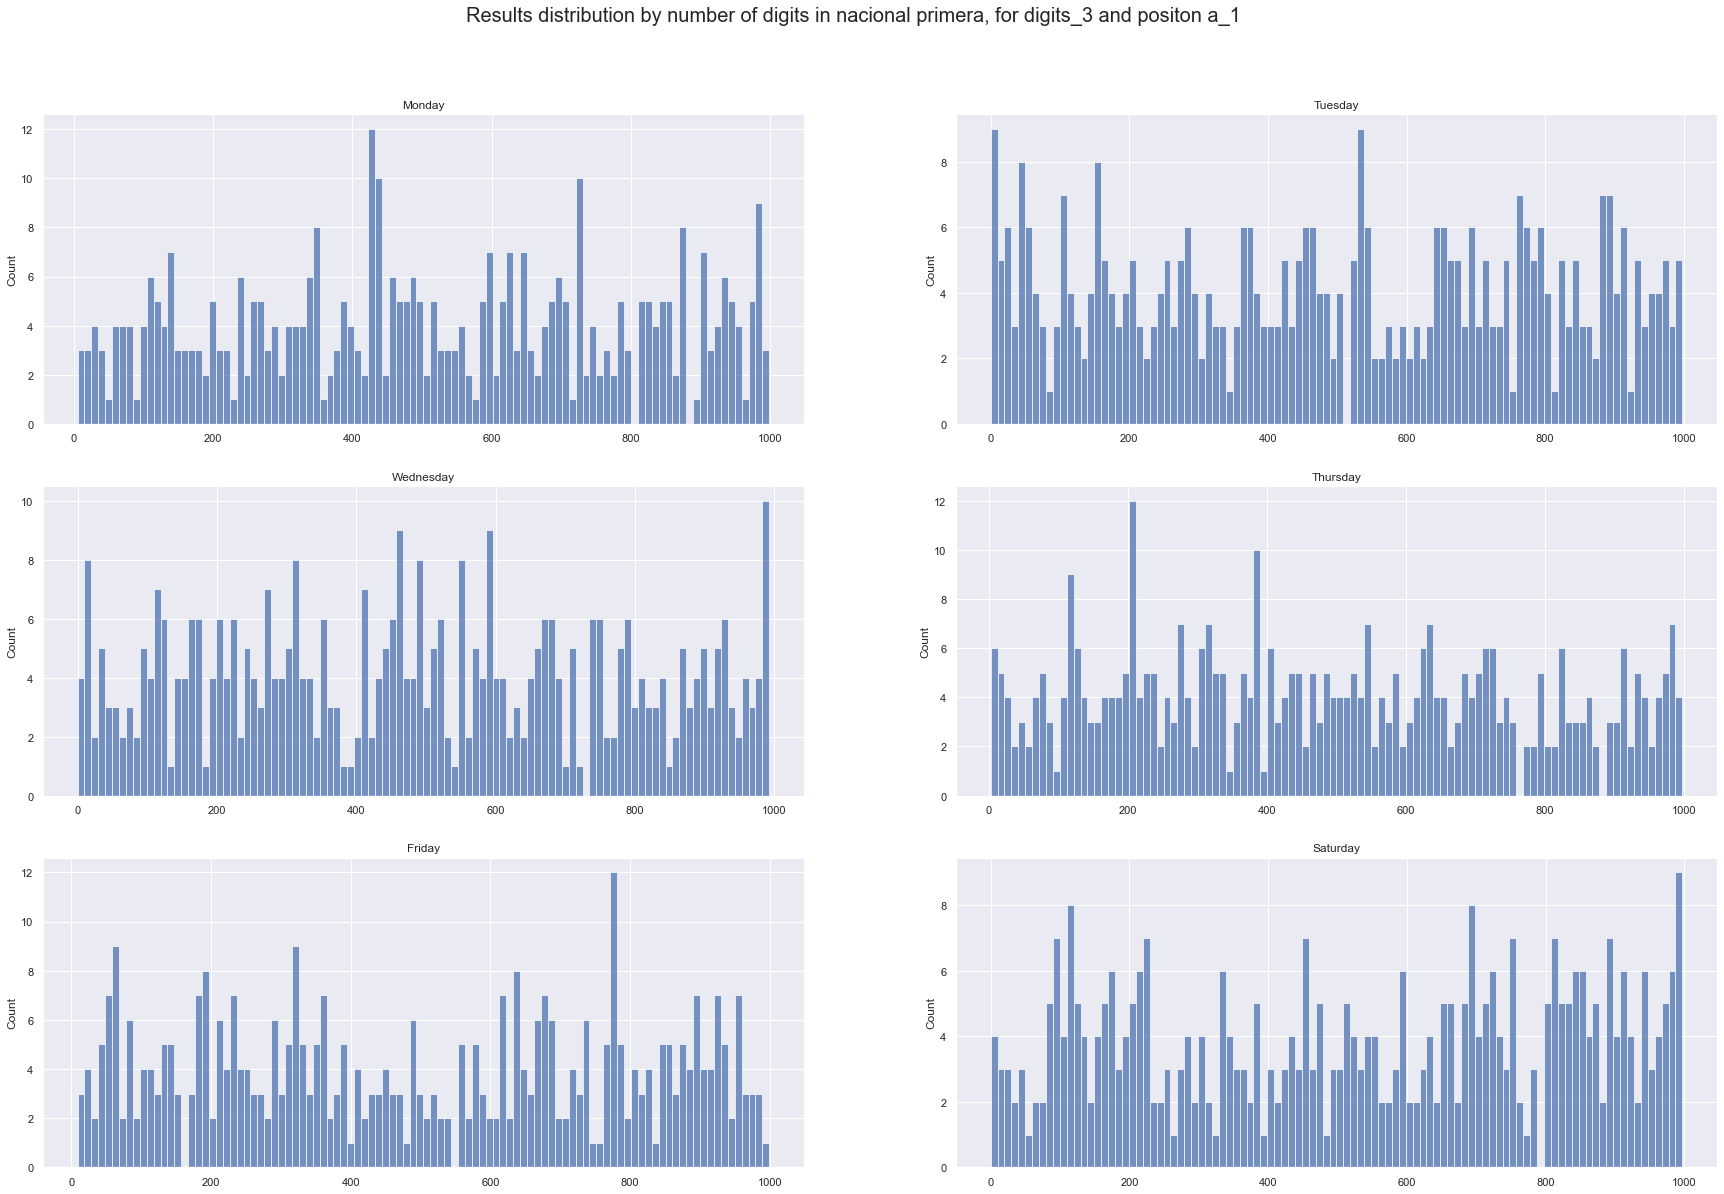

In [145]:
# Check distributions for 2 and 3 digits, at the first position, by the day of the week
display_occurrences_in_time('primera', 'digits_2', 'a_1')
display_occurrences_in_time('primera', 'digits_3', 'a_1')

>- *What is the distribution of the results by digit groups (2 digits), for the first position, taking as example the 'vespertina' period?*<br>
>&emsp;Distributions are multimodal<br>

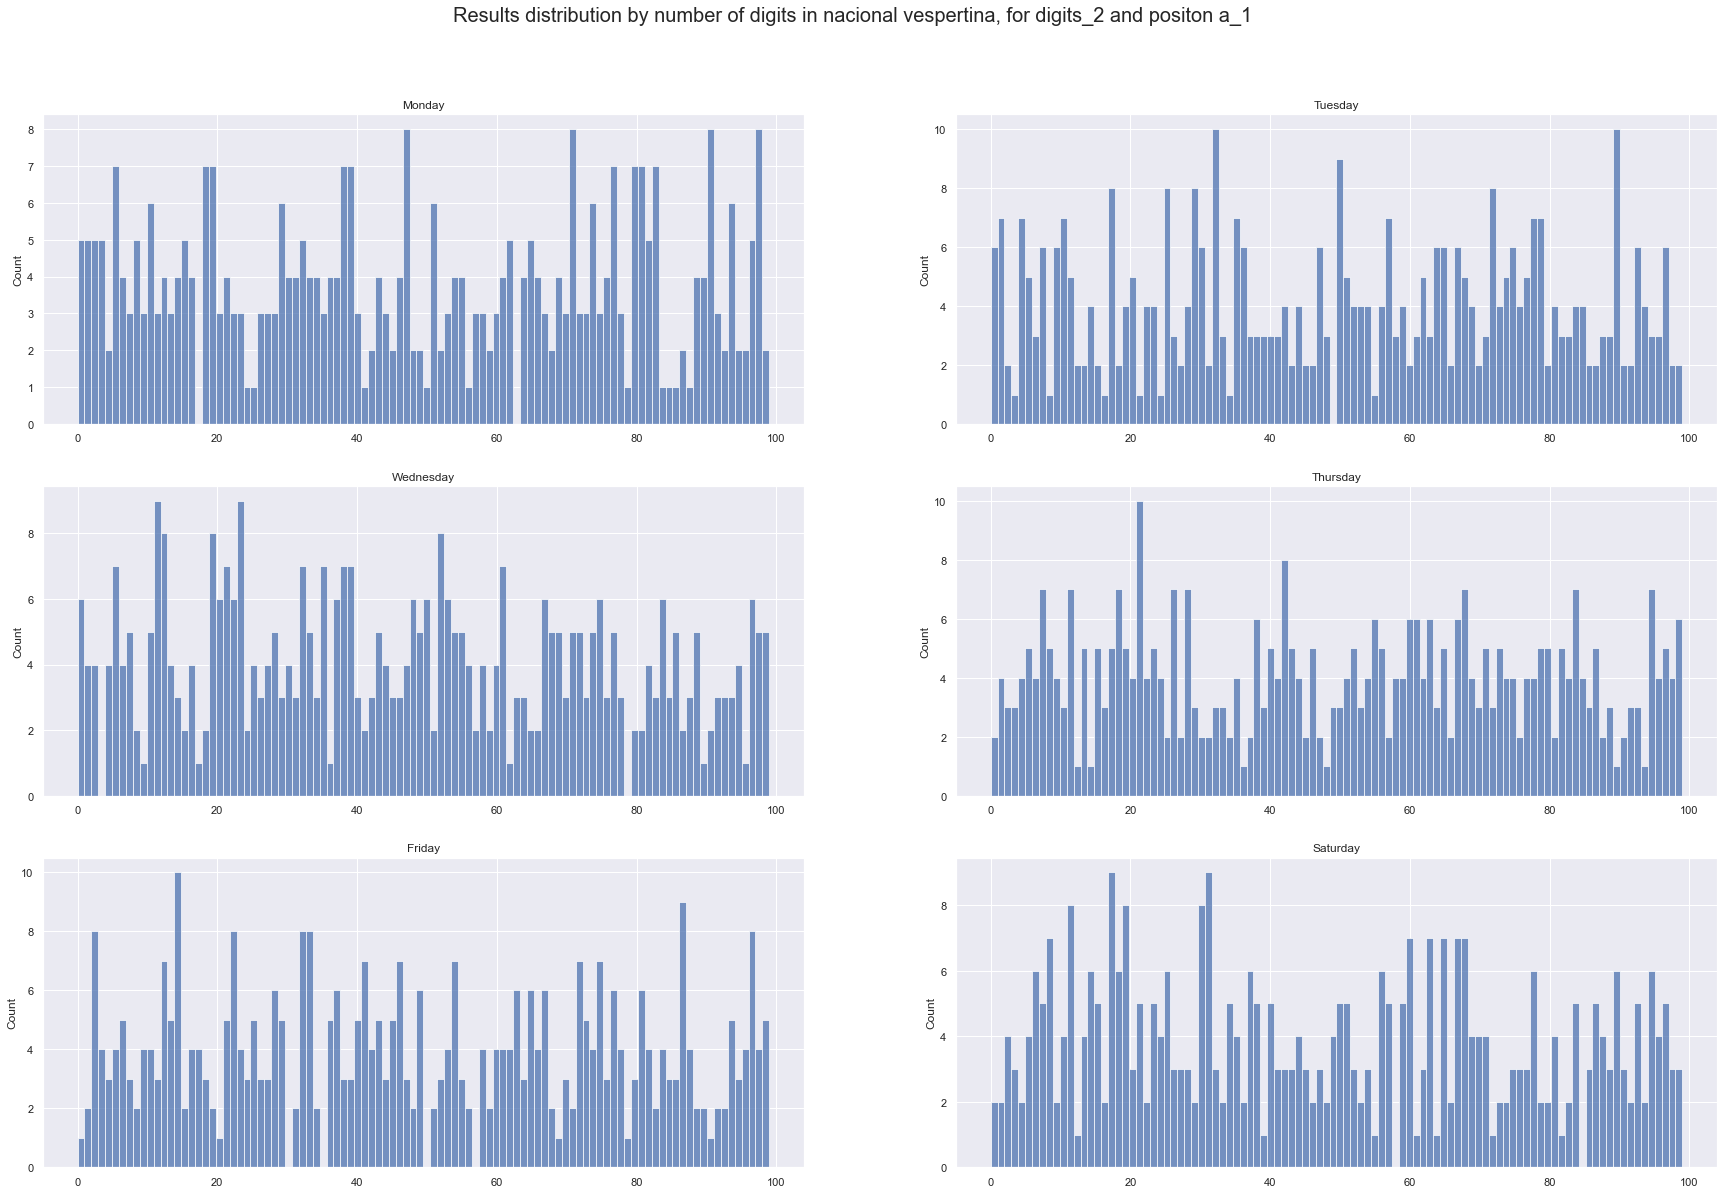

In [172]:
# Check distributions for 2 digits, at the first position, by the day of the week
display_occurrences_in_time('vespertina', 'digits_2', 'a_1')

<a id='day_of_week_modes'>Check modes by the day of the week</a>

In [ ]:
# Create a function to compare if modes from a certain group of digits, are also included in the following group (i.e., 2 digits in the 3 digits columns, and so on)
def check_modes(digit_2_mode_in, digit_3_mode_in, digit_4_mode_in):

    if digit_2_mode_in is in digit_3_mode_in

In [147]:
# Set width of columns to fit all values
pd.set_option('max_colwidth', None)
# Create table, grouping by period and calculating the mode for each grouped digits, for the first position
df_quiniela[df_quiniela['position_group'] == 'a_1'].groupby(['position_group', 'period', 'day_of_week']).agg(
    # list() is used to avoid errors. Arrays are not supported as a response
    digit_2_mode=('digits_2', lambda x: list(x.mode())), 
    digit_3_mode=('digits_3', lambda x: list(x.mode())),
    digit_4_mode=('digits_4', lambda x: list(x.mode()))
)

digit_2_mode  \
position_group period     day_of_week                     
a_1            matutina   0                        [71]   
                          1                        [11]   
                          2                        [18]   
                          3                    [44, 58]   
                          4                     [3, 11]   
                          5                        [12]   
               nocturna   0              [3, 5, 32, 71]   
                          1                        [96]   
                          2                        [64]   
                          3                        [29]   
                          4                    [41, 98]   
                          5                    [41, 59]   
               primera    0                        [30]   
                          1                        [90]   
                          2                        [77]   
                          3                 [3, 75, 82]   
                          4                    [54, 80]   
                          5                        [50]   
               vespertina 0            [47, 71, 91, 98]   
                          1                    [32, 90]   
                          2                    [11, 23]   
                          3                        [21]   
                          4                        [14]   
                          5                    [17, 31]   

                                                                       digit_3_mode  \
position_group period     day_of_week                                                 
a_1            matutina   0                                                   [171]   
                          1                                                   [496]   
                          2                                         [204, 612, 946]   
                          3             [5, 172, 188, 348, 439, 458, 511, 709, 980]   
                          4            [93, 217, 218, 308, 348, 544, 636, 654, 737]   
                          5                [189, 453, 565, 610, 694, 706, 725, 810]   
               nocturna   0                                                   [703]   
                          1                                                   [294]   
                          2                                                   [711]   
                          3                                                   [215]   
                          4                           [86, 155, 204, 331, 441, 869]   
                          5                                                   [259]   
               primera    0                                         [430, 877, 908]   
                          1                                [17, 200, 250, 460, 952]   
                          2                [226, 315, 328, 455, 496, 592, 785, 993]   
                          3                     [194, 203, 314, 323, 585, 696, 967]   
                          4                                              [781, 894]   
                          5                                                   [750]   
               vespertina 0                                                   [283]   
                          1                      [57, 336, 517, 647, 690, 917, 978]   
                          2                                                    [11]   
                          3                                                   [555]   
                          4                                               [45, 614]   
                          5                                                   [425]   

                                                                                                 digit_4_mode  
position_group period     day_of_week                                                                          
a_1            matuti

# **CHECK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

> Check matches between the modes of 2 digits, with 3 digits, and those same 3 digits, with 4 digits<br>
> *For example, matutina, Monday (0), has 71 for 2 digits, 171 for 3 digits, and 4171 for 4 digits*

### Transform categorical features with ...one-hot enconding?

### Check relationship between variables

<AxesSubplot:>

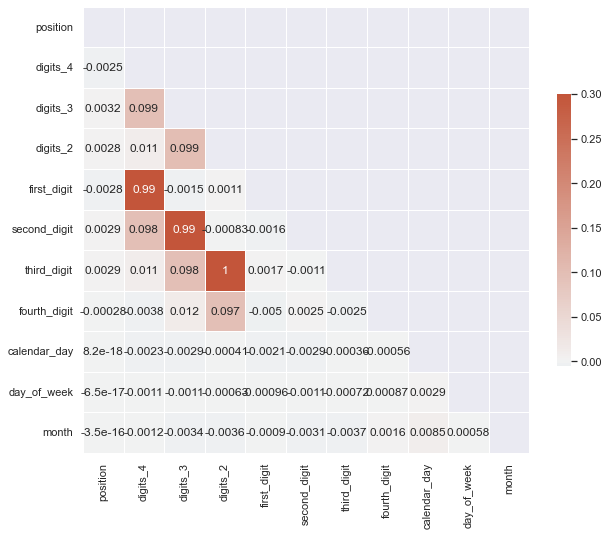

In [146]:
# Create the correlation matrix
corr = df_quiniela.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))
# Generate a custom diverging colormap
color_map = sns.diverging_palette(230, 20, as_cmap=True)
# Create the correlation matrix visual to be displayed
sns.heatmap(
    corr,
    mask=mask,
    cmap=color_map,
    vmax=.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': .5},
    annot=True
)

> It was expected that digits would be highly correlated between each other, considering them individually and also grouped. However, there are some, like the last 2 digits and the 4 digits, that are not highly correlated.